In [1]:
import pandas as pd
import sys
import py_entitymatching as em

In [2]:
import dask
import dask.dataframe as dd

In [3]:
# sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')
sys.path.append('/scratch/pradap/python-work/dmagellan/')

In [4]:
from dmagellan.core.downsample import *

In [5]:
# A = em.load_dataset('person_table_A')
# A.insert(0, 'id', range(len(A)))
# A.to_csv('A.csv', index=False)

In [95]:
import pandas
def preprocess_table(dataframe, idcol):
    strcols = list(get_str_cols(dataframe))
    strcols.append(idcol)
    projdf = dataframe[strcols]
    objsc = StringContainer()
    for row in projdf.itertuples():
        colvalues = row[1:-1]
        uid = row[-1]
        strings = [colvalue.strip() for colvalue in colvalues if not pd.isnull(colvalue)]
        concat_row = ' '.join(strings).lower()
        concat_row = concat_row.translate(None, string.punctuation)
        objsc.push_back(uid, str2bytes(concat_row))
    return objsc

def tokenize_strings(objsc, stopwords):
    n = objsc.size()
    objtc = TokenContainer()
    objtc.tokenize(objsc, stopwords)
    return objtc

def build_inv_index(objtc):
    inv_obj = InvertedIndex()
    inv_obj.build_inv_index_ds(objtc)
    return inv_obj

def probe(objtc, objinvindex, yparam):
    objprobe = Prober()
    objprobe.probe(objtc, objinvindex, yparam)
    return objprobe

def postprocess(result_list, ltable, rtable, lid, rid):
    lids = set()
    rids = set()
    for i in range(len(result_list)):
        result = result_list[i]
        lids.update(result.get_lids())
        rids.update(result.get_rids())
    lids = sorted(lids)
    rids = sorted(rids)
    if isinstance(ltable, pandas.core.frame.DataFrame):     
#         t_ltbl = ltable.set_index(lid, drop=True)
#         t_rtbl = ltable.set_index(rid, drop=True)
        s_ltable = ltable[ltable[lid].isin(lids)]
        s_rtable = rtable[rtable[rid].isin(rids)]
        return (s_ltable, s_rtable)
    else:
        s_ltable = ltable.map_partitions(lambda x: x[x[lid].isin(locs)])
        s_rtable = rtable.map_partitions(lambda x: x[x[rid].isin(locs)])
        return (s_ltable, s_rtable)
        
    

In [6]:
# downsample_pandas
def downsample_pandas(A, B, lid, rid, size, yparam, stopwords=[]):
    lstrings = preprocess_table(A, lid)
    ltokens = tokenize_strings(lstrings, stopwords)
    invindex = build_inv_index([ltokens])
    
    #rsample = B.sample(size, replace=False)
    rsample = B.head(size)
    rstrings = preprocess_table(rsample, rid)
    rtokens = tokenize_strings(rstrings, stopwords)
    
    probe_result = probe(rtokens, invindex, yparam)
    
    result = postprocess([probe_result], A, B, lid, rid)
    return result

In [7]:
# downsample delayed
import numpy as np
def downsample_delayed(A, B, lid, rid, size, yparam, nchunks=1, stopwords=[], compute=True):
    lstrings = (delayed)(preprocess_table)(A, lid)
    ltokens = (delayed)(tokenize_strings)(lstrings, stopwords)
    invindex = (delayed)(build_inv_index)([ltokens])
    
    #rsample = B.sample(size, replace=False)
    rsample = B.head(size)
    rsample_splitted = np.array_split(rsample, nchunks)
    probe_results = []
    for i in range(nchunks):
        rstrings = (delayed)(preprocess_table)(rsample, rid)
        rtokens = (delayed)(tokenize_strings)(rstrings, stopwords)
        probe_result = (delayed)(probe)(rtokens, invindex, yparam)
        probe_results.append(probe_result)
    
    result = (delayed)(postprocess)(probe_results, A, B, lid, rid)
    if compute:
        return result.compute()
    else:
        return result

In [8]:
# downsample delayed
import numpy as np
def downsample_dask(A, B, lid, rid, size, yparam, nchunks=1, stopwords=[], compute=True):
    lstrings = A.map_partition(preprocess_table, lid)
    ltokens = (delayed)(tokenize_strings)(lstrings, stopwords)
    invindex = (delayed)(build_inv_index)([ltokens])
    
    #rsample = B.sample(size, replace=False)
    rsample = B.head(size)
    rsample_splitted = np.array_split(rsample, nchunks)
    probe_results = []
    for i in range(nchunks):
        rstrings = (delayed)(preprocess_table)(rsample, rid)
        rtokens = (delayed)(tokenize_strings)(rstrings, stopwords)
        probe_result = (delayed)(probe)(rtokens, invindex, yparam)
        probe_results.append(probe_result)
    
    result = (delayed)(postprocess)(probe_results, A, B, lid, rid)
    if compute:
        return result.compute()
    else:
        return result

In [9]:
# A = em.load_dataset('person_table_A')
# B = em.load_dataset('person_table_B')
# A.insert(0, 'id', range(len(A)))
# B.insert(0, 'id', range(len(B)))
# A.to_csv('./person_A.csv', index=False)
# B.to_csv('./person_B.csv', index=False)

In [13]:
# pandas
A = pd.read_csv('./person_A.csv', low_memory=False)
B = pd.read_csv('./person_B.csv', low_memory=False)
result = downsample_pandas(A, B, 'id', 'id', 4, 1)


In [21]:
#delayed
A = pd.read_csv('./person_A.csv', low_memory=False)
B = pd.read_csv('./person_B.csv', low_memory=False)
result = downsample_delayed(A, B, 'id', 'id', 4, yparam=1, compute=False)

In [50]:
!ls

A.csv		mur-try2.ipynb	mur-try4.ipynb	mur-try6.ipynb	person_A.csv
mur-try1.ipynb	mur-try3.ipynb	mur-try5.ipynb	mydask.png	person_B.csv


In [10]:
# dask
A = dd.read_csv('../tracks.csv', blocksize=15000000)
B = dd.read_csv('../movies.csv', blocksize=15000000)

In [11]:
B

,id,title,year,length,budget,rating,votes,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,mpaa,Action,Animation,Comedy,Drama,Documentary,Romance,Short
npartitions=5,,,,,,,,,,,,,,,,,,,,,,,,,
None,int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,int64,int64,int64
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


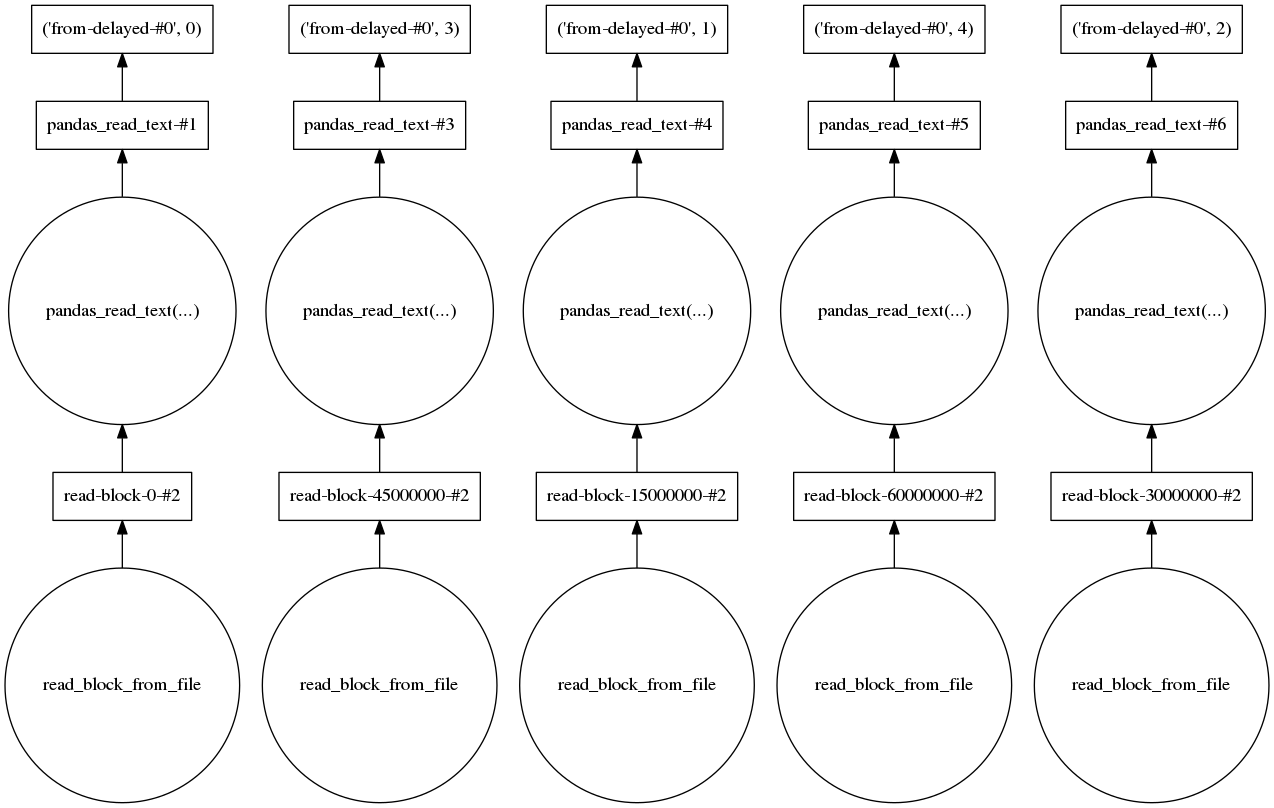

In [12]:
B.visualize()

In [59]:
def sample_df(df, idcol, size):
    n = len(df)
#     print(n)
    locs = np.random.choice(list(df[idcol].compute()), size)
    result = df.map_partitions(lambda x: x[x[idcol].isin(locs)])
    return result
    

In [60]:
ss = sample_df(B, 'id', 10)

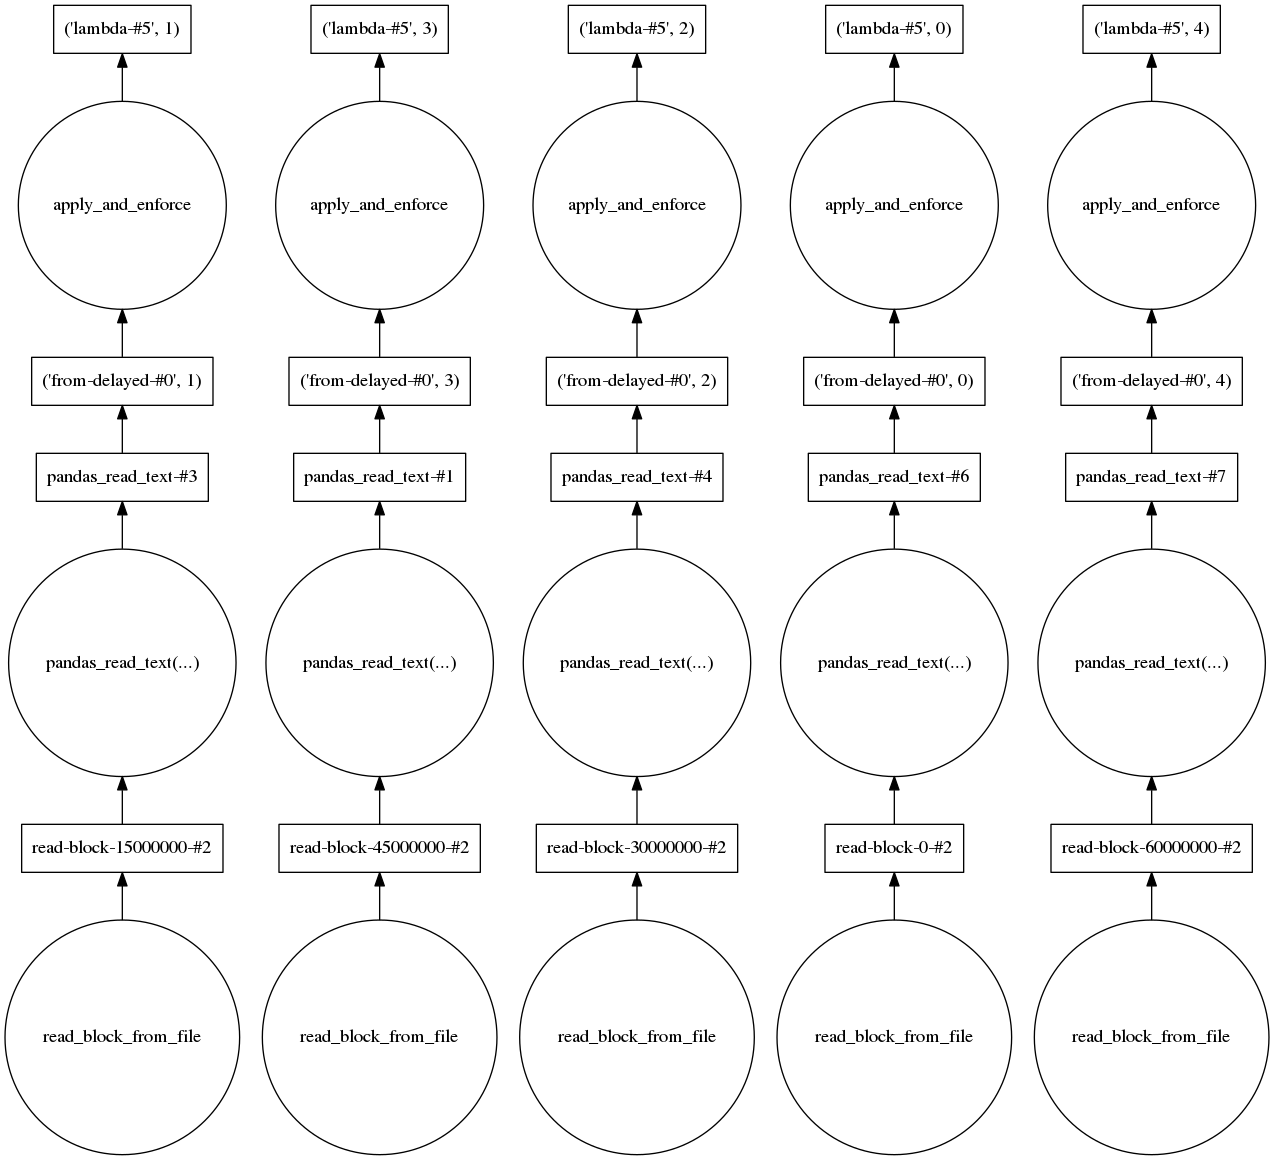

In [61]:
ss.visualize()

In [61]:
from dask import dataframe as dd

In [73]:
import os
def _get_stop_words():
    stop_words_set = set()
    install_path = em.get_install_path()
    dataset_path = os.sep.join([install_path, 'utils'])
    stop_words_file = os.sep.join([dataset_path, 'stop_words.txt'])
    with open(stop_words_file, "rb") as stopwords_file:
        for stop_words in stopwords_file:
            stop_words_set.add(stop_words.rstrip())

    return stop_words_set

In [1]:
stopwords=['all',
 'six',
 'less',
 'being',
 'indeed',
 'over',
 'move',
 'anyway',
 'four',
 'not',
 'own',
 'through',
 'yourselves',
 'fify',
 'where',
 'mill',
 'only',
 'find',
 'before',
 'one',
 'whose',
 'system',
 'how',
 'somewhere',
 'with',
 'show',
 'had',
 'enough',
 'should',
 'to',
 'must',
 'whom',
 'seeming',
 'whole',
 'under',
 'ours',
 'has',
 'might',
 'thereafter',
 'latterly',
 'do',
 'them',
 'his',
 'around',
 'than',
 'get',
 'very',
 'de',
 'none',
 'cannot',
 'every',
 'whether',
 'they',
 'front',
 'during',
 'thus',
 'now',
 'him',
 'nor',
 'name',
 'several',
 'hereafter',
 'always',
 'who',
 'cry',
 'whither',
 'this',
 'someone',
 'either',
 'each',
 'become',
 'thereupon',
 'sometime',
 'side',
 'two',
 'therein',
 'twelve',
 'because',
 'often',
 'ten',
 'our',
 'eg',
 'some',
 'back',
 'thickv',
 'go',
 'namely',
 'towards',
 'are',
 'further',
 'beyond',
 'ourselves',
 'yet',
 'out',
 'even',
 'will',
 'what',
 'still',
 'for',
 'bottom',
 'mine',
 'since',
 'please',
 'forty',
 'per',
 'its',
 'everything',
 'behind',
 'un',
 'above',
 'between',
 'it',
 'neither',
 'seemed',
 'ever',
 'across',
 'she',
 'somehow',
 'be',
 'we',
 'full',
 'never',
 'sixty',
 'however',
 'here',
 'otherwise',
 'were',
 'whereupon',
 'nowhere',
 'although',
 'found',
 'alone',
 're',
 'along',
 'fifteen',
 'by',
 'both',
 'about',
 'last',
 'would',
 'anything',
 'via',
 'many',
 'could',
 'thence',
 'put',
 'against',
 'keep',
 'etc',
 'amount',
 'became',
 'ltd',
 'hence',
 'onto',
 'or',
 'con',
 'among',
 'already',
 'co',
 'afterwards',
 'formerly',
 'within',
 'seems',
 'into',
 'others',
 'while',
 'whatever',
 'except',
 'down',
 'hers',
 'everyone',
 'done',
 'least',
 'another',
 'whoever',
 'moreover',
 'couldnt',
 'throughout',
 'anyhow',
 'yourself',
 'three',
 'from',
 'her',
 'few',
 'together',
 'top',
 'there',
 'due',
 'been',
 'next',
 'anyone',
 'eleven',
 'much',
 'call',
 'therefore',
 'interest',
 'then',
 'thru',
 'themselves',
 'hundred',
 'was',
 'sincere',
 'empty',
 'more',
 'himself',
 'elsewhere',
 'mostly',
 'on',
 'fire',
 'am',
 'becoming',
 'hereby',
 'amongst',
 'else',
 'part',
 'everywhere',
 'too',
 'herself',
 'former',
 'those',
 'he',
 'me',
 'myself',
 'made',
 'twenty',
 'these',
 'bill',
 'cant',
 'us',
 'until',
 'besides',
 'whenever',
 'below',
 'anywhere',
 'nine',
 'can',
 'of',
 'your',
 'toward',
 'my',
 'something',
 'and',
 'whereafter',
 'give',
 'almost',
 'wherever',
 'is',
 'describe',
 'beforehand',
 'herein',
 'an',
 'as',
 'itself',
 'at',
 'have',
 'in',
 'seem',
 'whence',
 'ie',
 'any',
 'fill',
 'again',
 'hasnt',
 'inc',
 'thereby',
 'thin',
 'no',
 'perhaps',
 'latter',
 'meanwhile',
 'when',
 'detail',
 'same',
 'wherein',
 'beside',
 'also',
 'that',
 'other',
 'take',
 'which',
 'becomes',
 'you',
 'if',
 'nobody',
 'see',
 'though',
 'may',
 'after',
 'upon',
 'most',
 'hereupon',
 'eight',
 'but',
 'serious',
 'nothing',
 'such',
 'why',
 'a',
 'off',
 'whereby',
 'third',
 'nevertheless',
 'up',
 'noone',
 'sometimes',
 'well',
 'amoungst',
 'yours',
 'their',
 'rather',
 'without',
 'so',
 'five',
 'the',
 'first',
 'whereas',
 'once',
 'the',
 'my',
 'i',
 'andre',
 'from']

In [2]:
sorted(stopwords)

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'andre',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fify',
 'fill',
 'find',
 'fire',
 'first',
 'five

In [90]:
rsample.map_partitions(len).compute()

0    2283
1    2273
2    2317
3    2231
4     834
dtype: int64

In [15]:
from dask.distributed import Client

In [16]:
client = Client()

In [70]:
type(A)

dask.dataframe.core.DataFrame

In [103]:
import numpy as np
size=10000
yparam=1
lstrings = []
for i in range(A.npartitions):
    lstrings.append((delayed)(preprocess_table)(A.get_partition(i), 'id'))
ltokens = []
for i in range(len(lstrings)):
    ltokens.append((delayed)(tokenize_strings)(lstrings[i], stopwords))
invindex = (delayed)(build_inv_index)(ltokens)

rsample = (sample_df)(B, 'id', size)
rsample.repartition(npartitions=2)
probe_results = []
for i in range(rsample.npartitions):
    rstrings = (delayed)(preprocess_table)(rsample.get_partition(i), 'id')
    rtokens = (delayed)(tokenize_strings)(rstrings, stopwords)
    presult = (delayed)(probe)(rtokens, invindex, yparam)
    probe_results.append(presult)

# need to split this into two functions    
result = (delayed)(postprocess)(probe_results, A, rsample, 'id', 'id')
    

TypeError: Delayed objects of unspecified length are not iterable

In [97]:
with ProgressBar():
    res = result.compute(get=threaded.get)

[########################################] | 100% Completed | 19.7s


In [102]:
type(result[0])

dask.delayed.Delayed

In [73]:
rsample = (sample_df)(B, 'id', size)

In [80]:
xx.head()

,id,title,year,length,budget,rating,votes,r1,r2,r3,...,r9,r10,mpaa,Action,Animation,Comedy,Drama,Documentary,Romance,Short
32,598183,Risk,2015,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,1,0,0,1
101,598252,Risto and Minna,2006,74.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,0
211,598362,Rithubhedam,1986,126.0,NaN,7.8,9.0,0.0,14.5,0.0,...,24.5,24.5,NaN,0,0,0,0,0,0,0
266,598417,Ritorno dalla pesca nell'Adriatico (San Benedetto del Tronto),1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,1,0,1
314,598465,Rittmeister Wronski,1954,99.0,NaN,5.6,17.0,4.5,0.0,24.5,...,0.0,4.5,NaN,0,0,0,0,0,0,0


In [85]:
    rstrings = (delayed)(preprocess_table)(rsample.get_partition(3), 'id')
    rtokens = (delayed)(tokenize_strings)(rstrings, stopwords)
    presult = (delayed)(probe)(rtokens, index, yparam)



In [91]:
!mkdir temp

In [92]:
rsample.get_partition(3).to_csv('temp')

In [87]:
with ProgressBar():
    xx = presult.compute(get=threaded.get)

[########################################] | 100% Completed |  1min  9.3s


In [94]:
index.values('The')

[1,
 2,
 3,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 43,
 51,
 66,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 193,
 194,
 195,
 198,
 208,
 213,
 215,
 221,
 224,
 228,
 229,
 230,
 336,
 337,
 341,
 344,
 398,
 451,
 462,
 464,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 514,
 517,
 526,
 532,
 541,
 542,
 546,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 634,
 652,
 655,
 663,
 666,
 671,
 689,
 703,
 912,
 920,
 933,
 940,
 964,
 973,
 98

In [34]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar

In [27]:
from dask import threaded

In [65]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    r = result.compute(get=threaded.get)

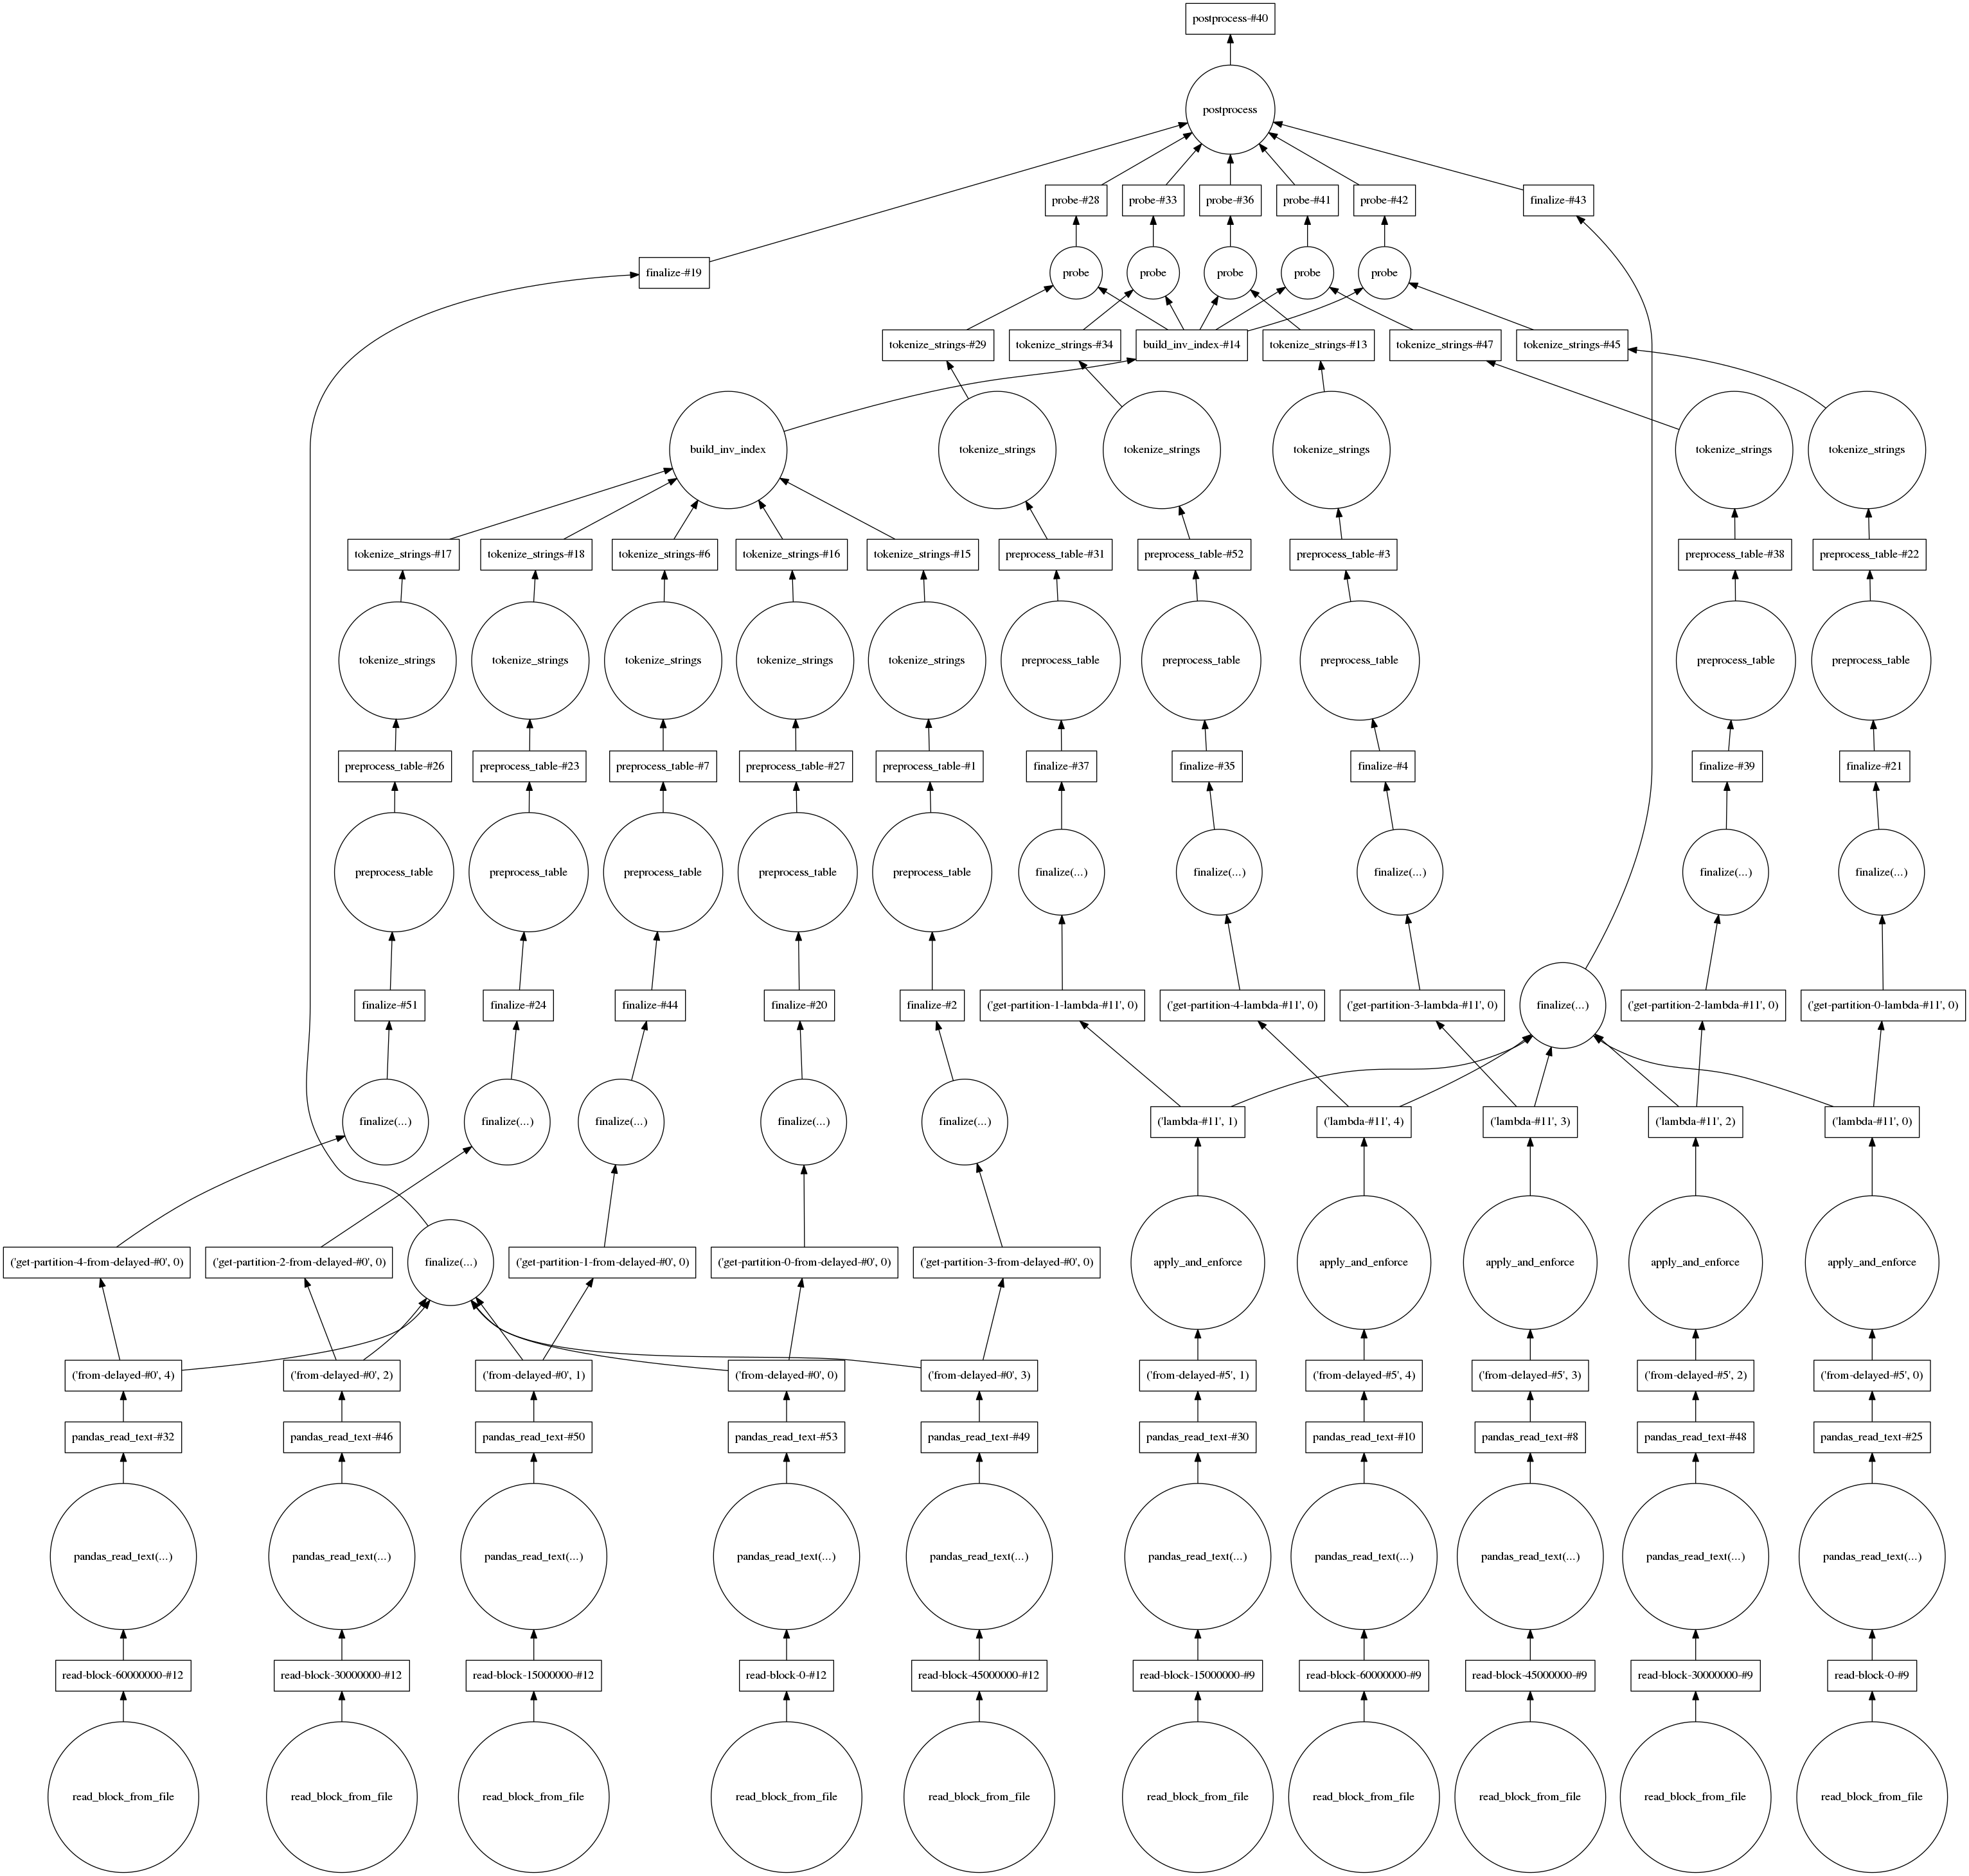

In [69]:
result.visualize()

In [66]:
prof.visualize()

Figure(id='ca1c42f3-f1c7-488e-a062-294e16db6854', ...)

In [44]:
invindex.values('the')

[]

In [58]:
with ProgressBar():
    x = probe_results[4].compute(get=threaded.get)

[########################################] | 100% Completed | 18.7s


In [52]:
a, b = x.get_lids(), x.get_rids()

In [54]:
len(a), len(b)

(1907, 1997)

In [40]:
with ProgressBar():
    rs = rsample.compute(get=threaded.get)

[########################################] | 100% Completed |  1.8s


In [31]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    sampled_tables = result.compute(get=threaded.get)

In [32]:
prof.visualize()

Figure(id='5ed2d594-604e-4cca-95b3-fb58a909b220', ...)

In [33]:
result.dask.keys()

['preprocess_table-046a961d-ef40-451b-98e9-831c43042037',
 'read-block-0-c0987aee0736ecf593b332dcedac01f7',
 'finalize-5c8efff2a5cdcccfeefba62d822d57c5',
 ('get-partition-0-from-delayed-f376c014e07f8ddffd9c03104b7bac97', 0),
 ('from-delayed-f376c014e07f8ddffd9c03104b7bac97', 0),
 'pandas_read_text-dcf60b499872fe9960185c2aa4f201ff',
 ('get-partition-2-lambda-f4a71ea257d0f68dd87d15183215e6e4', 0),
 'finalize-f5062c96a53b62ff5e6175c4195052e6',
 'read-block-30000000-d7adde126f6b9f7f1ba7689f57c7d8f9',
 'pandas_read_text-4717a0c68f49a9dd4de2fb4a7d6b27c0',
 ('lambda-f4a71ea257d0f68dd87d15183215e6e4', 2),
 ('from-delayed-bc791db8a9034ad18101bceb8bcf99c7', 2),
 'preprocess_table-3c1a098c-647b-4d23-9301-95e5d590e064',
 'tokenize_strings-66fc1c96-0294-45f5-be0f-105e16bab4b3',
 'preprocess_table-9c45498e-8fec-47fe-96cd-d6ac4c09bd7e',
 'probe-699ca056-c5b1-4e32-af16-e649353a9451',
 'build_inv_index-7f2ffa34-3196-4a6a-a510-e439665ecf2e',
 'tokenize_strings-f52e7129-b414-478c-ba88-35c0d97d95ba',
 'pa

In [80]:
len(sampled_tables[0])

8227

In [48]:
result.compute()[0]

,id,ID,name,birth_year,hourly_wage,address,zipcode
0,0,a1,Kevin Smith,1989,30.0,"607 From St, San Francisco",94107
0,1,a2,Michael Franklin,1988,27.5,"1652 Stockton St, San Francisco",94122
1,2,a3,William Bridge,1986,32.0,"3131 Webster St, San Francisco",94107
0,4,a5,Alphonse Kemper,1984,35.0,"1702 Post Street, San Francisco",94122


In [33]:
rsample = (sample_df)(B, 'id', 4)

In [38]:
rsample.repartition(npartitions=2)

dd.DataFrame<reparti..., npartitions=2>

In [117]:
sample_locs.npartitions

5

In [14]:
result[1]

,id,ID,name,birth_year,hourly_wage,address,zipcode
0,0,b1,Mark Levene,1987,29.5,"108 Clement St, San Francisco",94107
1,1,b2,Bill Bridge,1986,32.0,"3131 Webster St, San Francisco",94107
2,2,b3,Mike Franklin,1988,27.5,"1652 Stockton St, San Francisco",94122
3,3,b4,Joseph Kuan,1982,26.0,"108 South Park, San Francisco",94122
